# Performance di segmentazione

In questo notebook analizzeremo le performance di segmentazione del modello guardando a **Dice coefficient** e **foreground accuracy** come metriche.

Il codice è molto simile a quanto presentato in questo modulo, con la sola accortezza di **incrementare la batch size in modo da evitare valori *NaN* per la foreground accuracy**. Ciò può capitare se nel batch sono presenti immagini senza cellule a cui corrisponde una previsione corretta, per cui l'accuratezza sui pixel delle cellule si riduce al rapporto tra  0 pixel di classe "cellula" nella maschera e 0 nella previsione.
Aumentando la batch size si riduce tuttavia il rischio di avere solo immagini vuote.

Inoltre elimineremo tutte le trasformazioni ad eccezione del resize per testare il modello solamente su immagini originali, così da avere delle misure più veritiere dell'utilizzo reale.

<div class="alert alert-block alert-info">

Di seguito utilizzeremo solo il **modello costruito con la DiceLoss**, tuttavia il codice è facilmente riusabile per gli altri modelli. L'unica cosa da cambiare è la cartella dove pescare il modelle pre-allenato.
</div>

In [1]:
import sys
from fastai.vision.all import *

sys.path.insert(0, str(Path.cwd().parent))

from utils import write_config, load_config


# data and augmentation params
BS = 16
RESIZE = 224

# model params
N_IN, N_OUT = 16, 2

# optimizer params
LOSS_FUNC, LOSS_NAME = DiceLoss(axis=1, smooth=1e-06, reduction='mean', square_in_union=False), 'Dice'

EXP_NAME = "Dice"
log_path = Path().cwd().parent / 'logs' / EXP_NAME  
model_path = log_path.parent.parent / f'models/{EXP_NAME}'

## Dataloader

/home/luca/anaconda3/envs/fx/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/home/luca/anaconda3/envs/fx/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-b

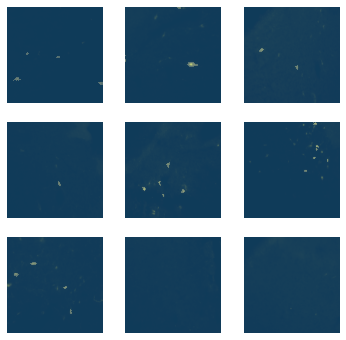

In [2]:
data_path = Path('../fluocells_data/all_images')

# read train/valid/test split dataframe
split_df = pd.read_csv(data_path.parent / 'split_df.csv')
trainval_fnames = [data_path / 'images' / fn
                   for fn in split_df.query("split=='train' or split=='valid'").filename]

def label_func(p):
    return Path(str(p).replace('images', 'masks'))

def is_valid(p):
    return split_df.loc[split_df.filename == p.name, 'split'].values[0] == 'valid'

# augmentation
tfms = [
    IntToFloatTensor(div_mask=255.),  # need masks in [0, 1] format
#     RandomCrop(CROP_SIZE),
    *aug_transforms(
        size=RESIZE, # resize
    )
]


# splitter
splitter = FuncSplitter(lambda p: is_valid(p))

# dataloader
dls = SegmentationDataLoaders.from_label_func(
    data_path, fnames=trainval_fnames, label_func=label_func,
    bs=BS,
    splitter=splitter,
    batch_tfms=tfms,
    device='cpu'
)

dls.show_batch(max_n=9, figsize=(6,6))

### Test dataloader

In questo caso siamo interessati a valutare le performance del modello fuori campione.

Per questo motivo aggiungeremo un dataloader che va a pescare direttamente le 28 immagini di test.

Numero immagini di test: 28


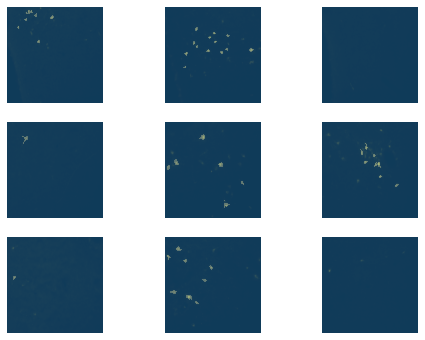

In [3]:
test_fnames = [data_path / 'images' / fn
                   for fn in split_df.query("split=='test'").filename]

print(f"Numero immagini di test: {len(test_fnames)}")
test_dl = dls.test_dl(test_fnames, with_labels=True)
test_dl.show_batch(figsize=(8,6))

## Learner

Anche in questo caso possiamo riutilizzare il codice sfruttato nel training.

Eviteremo tuttavia le callback e le metriche che al momento non ci interessano per l'ispezione visiva.

In [4]:
from blocks import cResUnet

model = cResUnet(N_IN, N_OUT)

learn = Learner(dls, model=model, loss_func=LOSS_FUNC,
                metrics=[Dice, foreground_acc],
                path=log_path , 
                model_dir=model_path,
                )  

print(
    f'Logs save path: {learn.path}\nModel save path: {learn.path / learn.model_dir}')

learn.summary()

Logs save path: /home/luca/PycharmProjects/c-resunet-DLI/logs/Dice
Model save path: /home/luca/PycharmProjects/c-resunet-DLI/models/Dice


cResUnet (Input shape: 16 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 1 x 224 x 224  
Conv2d                                    4          True      
BatchNorm2d                               2          True      
ELU                                                            
____________________________________________________________________________
                     16 x 16 x 224 x 224 
Conv2d                                    160        True      
BatchNorm2d                               32         True      
ELU                                                            
Conv2d                                    2320       True      
____________________________________________________________________________
                     16 x 16 x 112 x 112 
MaxPool2d                                                      
BatchNorm2d                               32         True      
ELU                                  

## Load model

Una volta definito l'oggetto `Learner`, il modello verrà inizializzato con pesi random come di consueto. 

Per sfruttare i pesi pre-allenati dovremo quindi ripescarli da dove li avevamo salvati con `SaveModelCallback`.

Per fare ciò basta sfruttare il metodo `.load(file)` che andrà a caricare i pesi salvati nel file con estensione *.pth*.

In [5]:
print(f"Loading pesi da: {model_path}")

learn.load(model_path / 'model') # model.pth

Loading pesi da: /home/luca/PycharmProjects/c-resunet-DLI/models/Dice


# Performance



In [6]:
# validation set
res = learn.validate()

metrics_df = pd.DataFrame(data={'loss': res[0], 'Dice': res[1], 'foreground_accuracy': res[2]}, index=['valid'])

In [7]:
# test set
res = learn.validate(dl=test_dl)
metrics_df.loc['test'] = res
metrics_df

,loss,Dice,foreground_accuracy
valid,0.566614,0.700291,0.849832
test,0.567540,0.685176,0.863266


Come prima cosa possiamo osservare che abbiamo una **loss abbastanza stabile** tra validation e test set, segno che non dovremmo avere problemi di overfitting.

Guardando alle 2 metriche, i risultati variano leggermente e in senso opposto. Questo testimonianza come ciascuna metrica metta in risalto peculiarità diverse, per cui la valutazione dipende sempre dalle priorità specifiche di ogni esperimento.
Nel nostro caso daremo maggior peso al dice coefficient, tuttavia la foreground accuracy fornisce un'informazione complementare che può tornare utile, quindi è sempre bene guardare più metriche insieme.

Il dice coefficient si attesta attorno a *0.685*, a significare che le maschere predette e quelle reali si sovrappongono per quasi il 70% dei pixel. Questo è sicuramente un buon risultato per un'applicazione reale, soprattutto considerando che gran parte dei mismatch sono dovuti a:
 - falsi positivi/negativi, che però in alcuni casi possono essere soggettivi
 - pixel del contorno delle cellule, quindi il modello può aver riconosciuto la cellula ma c'è un po' di discrepanza tra la segmentazione manuale e quella automatica
 
Focalizzandoci solamente sui pixel delle cellule, notiamo invece che l'accuratezza su questa classe supera l'85%. Questo conferma che il dice coefficient alto non è dovuto solamente ad una buona sovrapposizione dello sfondo data la sua predominanza.